In [2]:
import numpy as np
import pandas as pd

In [3]:
def load_data(path, headers=None, skiprows=0):
	data = pd.read_csv(path, skiprows=skiprows)
	time = np.ravel(data[data.columns[0]].to_numpy())
	sig = np.ravel(data[data.columns[1]].to_numpy())
	return time, sig


In [4]:
def overlapped_allan_variance(sig, fs):
	t0 = 1 / fs
	sense = np.cumsum(sig*t0)
	maxNumM = 100
	L = len(sense)
	maxM = 2**np.floor(np.log2(L/2))
	m = np.logspace(np.log10(1), np.log10(maxM), maxNumM)
	m = np.ceil(m)
	m = np.unique(m)
	tau = m * t0

	avar = np.zeros(m.size)
	for i in range(m.size):
		mi = int(m[i])
		avar[i] = np.sum((sense[2*mi:L]- 2*sense[mi:L-mi] + sense[:L-2*mi])**2)

	avar /= (2*tau**2 * (L-2*m))

	return tau, avar

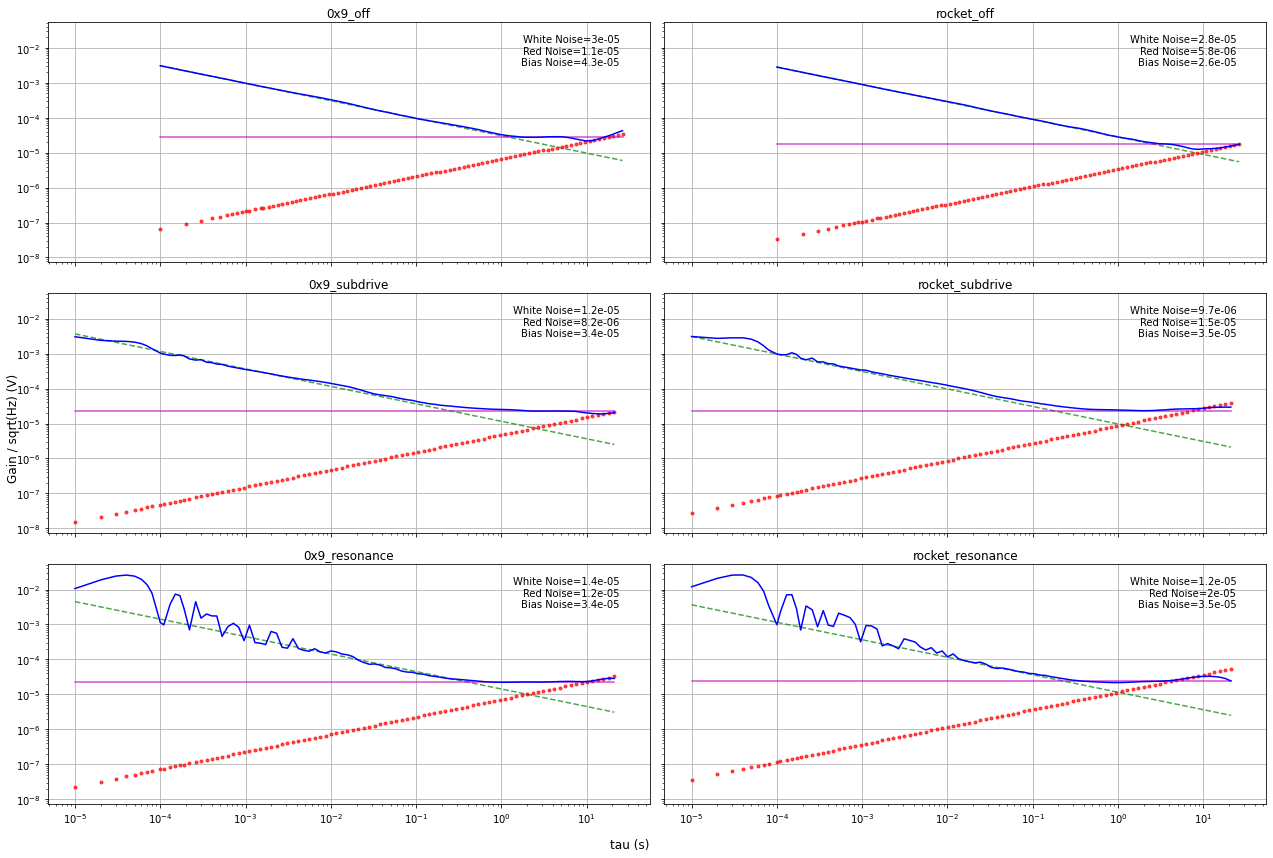

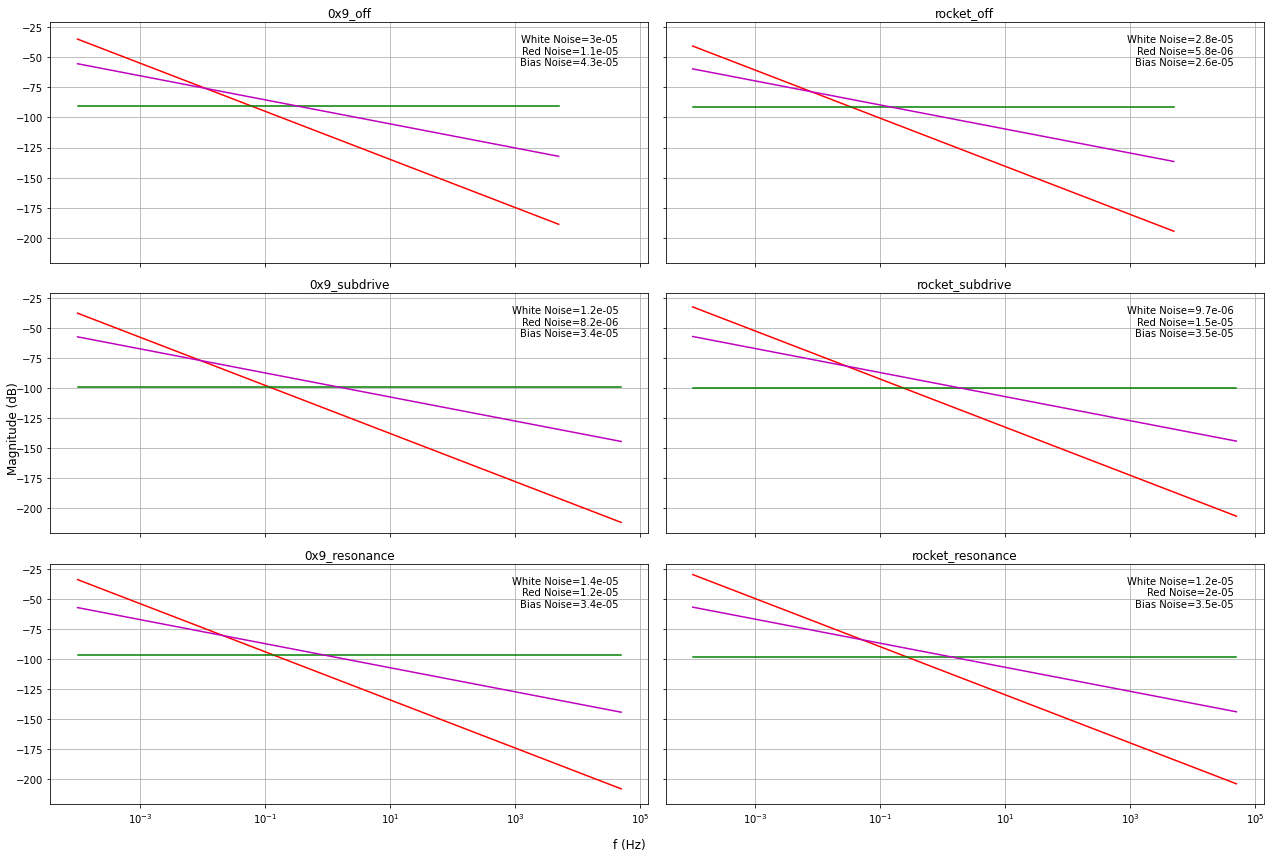

In [22]:
from pathlib import Path
import matplotlib.pyplot as plt

DIRECTORY = "noise"
files = Path(DIRECTORY).glob('*')
Qs = []
heights = []
f0s = []
fig, axes = plt.subplots(3, 2, sharex='all', sharey='all')
fig2, axes2 = plt.subplots(3, 2, sharex='all', sharey='all')
count = 0
file_names = {"off": 0, "subdrive": 1, "resonance": 2}
for file in files:
     if file.suffix == '.csv':
          ax = None
          ax2 = None
          row = file_names[file.stem.split("_")[-1]]
          col = 0 if '0x9' in str(file) else 1
          ax = axes[row, col]
          ax2 = axes2[row, col]

          count += 1
          dtime, dsignal = load_data(file, skiprows=22)
          t0 = np.mean(np.ediff1d(dtime))
          fs = 1 / t0
          t0 = round(t0, 10)
          fs = round(fs, 10)
          tau, avar = overlapped_allan_variance(dsignal, fs)
          adev = np.sqrt(avar)
          # find the index where the slope of the log-scaled Allan deviation is equal to the slope specified
          slope = -1/2
          logtau = np.log10(tau)
          logadev = np.log10(adev)
          dlogadev = np.diff(logadev) / np.diff(logtau)
          idx = np.argmin(np.abs(dlogadev - slope))

          # find the y intercept of the line
          b = logadev[idx] - slope*logtau[idx]
          logN = slope*np.log10(1) + b
          N = 10**logN

          tauN = 1
          lineN = N / np.sqrt(tau)

          slope = 0.5
          idx = np.argmin(np.abs(dlogadev[-10:] - slope))
          idx += dlogadev.size - 10
          b = logadev[idx] - slope*logtau[idx]

          logK = slope*np.log10(3) + b
          K = 10**logK
          lineK = K * np.sqrt(tau / 3)

          slope = 0.0
          idx = np.argmin(np.abs(dlogadev[-15:-10] - slope))
          idx += dlogadev.size - 15
          b = logadev[idx] - slope*logtau[idx]

          scfB = np.sqrt(2 * np.log(2) / np.pi)
          logB = b - np.log10(scfB)
          B = 10**logB
          lineB = B * scfB * np.ones(tau.size)

          ax.set_title(f'{file.stem}')
          ax.set_xscale('log')
          ax.set_yscale('log')
          ax.grid()
          ax.plot(tau, lineN, '--', color='g', alpha = 0.7)
          ax.plot(tau, lineK, '.', color='r', alpha = 0.7)
          ax.plot(tau, lineB, '-', color='m', alpha = 0.7)
          ax.plot(tau, adev, color='b')
          ax.text(0.95, 0.95, f'White Noise={N:.02}\nRed Noise={K:.02}\nBias Noise={B:.2}', horizontalalignment='right',
               verticalalignment='top', transform=ax.transAxes, wrap=True)


          w = np.linspace(0.0001, fs / 2, 1000)

          noise_white = [N**2] * len(w)
          noise_red = (K / 2 / np.pi)**2 / w**2
          noise_pink = B**2 / 2 / np.pi / w

          noise_white = 10*np.log10([N**2] * len(w))
          noise_red = 10*np.log10((K / 2 / np.pi)**2 / w**2)
          noise_pink = 10*np.log10((B**2 / 2 / np.pi / w))

          ax2.set_title(f'{file.stem}')
          ax2.set_xscale('log')
          #ax2.set_yscale('log')
          ax2.grid()
          ax2.plot(w, noise_red, 'r')
          ax2.plot(w, noise_white, 'g')
          ax2.plot(w, noise_pink, 'm')
          ax2.text(0.95, 0.95, f'White Noise={N:.02}\nRed Noise={K:.02}\nBias Noise={B:.2}', horizontalalignment='right',
               verticalalignment='top', transform=ax2.transAxes, wrap=True)

fig.set_figheight(fig.get_figheight()*3)
fig.set_figwidth(fig.get_figwidth()*3)
fig.supxlabel("tau (s)")
fig.supylabel("Gain / sqrt(Hz) (V)")
fig.tight_layout()
fig.savefig(f'{DIRECTORY}/avar.png')

fig2.set_figheight(fig2.get_figheight()*3)
fig2.set_figwidth(fig2.get_figwidth()*3)
fig2.supxlabel("f (Hz)")
fig2.supylabel("Magnitude (dB)")
fig2.tight_layout()
fig2.savefig(f'{DIRECTORY}/pds.png')


White noise spectrum

\begin{equation}
S_A(f) = N^2
\end{equation}

\begin{equation}
\sigma^2(\tau) = \frac{N^2}{\tau}
\end{equation}

Red noise (brownian noise) spectrum

\begin{equation}
S_A(f) = (\frac{K}{2\pi})^2\frac{1}{f^2}
\end{equation}

\begin{equation}
\sigma^2(\tau) = \frac{K^2\tau}{3}
\end{equation}

Bias instability due to pink noise (flickr noise) spectrum

\begin{equation}
S_A(f)=(\frac{B^2}{2\pi})\frac{1}{f}
\end{equation}

\begin{equation}
\sigma^2(\tau) = \frac{2B^2}{\pi}[ln{2} -\frac{\sin{x}^2}{2x^2}(\sin{x}+4x\cos{x})+Ci(2x)-Ci(4x)]
\end{equation}

$ Ci $ is the cosine integration function and $x = 2\pi f_0 \tau$

In [23]:
N, K, B

(9.721998031951234e-06, 1.4955349444804573e-05, 3.5184371977073005e-05)